In [1]:
# Data from - https://www.clips.uantwerpen.be/conll2000/chunking/

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report

In [3]:
def prepare_data(file_path):
    sentences = []
    tags = []
    with open(file_path, "r", encoding="utf-8") as f:
        sentence = []
        pos_tags = []
        for line in f:
            line = line.strip()
            if line == "":  # Sentence boundary
                if sentence:
                    sentences.append(sentence)
                    tags.append(pos_tags)
                    sentence = []
                    pos_tags = []
            else:
                parts = line.split()
                if len(parts) >= 2:  # Ensure the line has at least word and POS tag
                    word, pos_tag = parts[0], parts[1]
                    sentence.append(word)
                    pos_tags.append(pos_tag)
        if sentence:
            sentences.append(sentence)
            tags.append(pos_tags)
    return sentences, tags

In [4]:
file_path = "./data/train.txt"
sentences, pos_tags = prepare_data(file_path)

In [62]:
word_vocab = {word: idx for idx, word in enumerate(set(w for s in sentences for w in s), start=1)} # word to index mapping
word_vocab["<PAD>"] = 0  # For padding
word_vocab["<UNK>"] = len(word_vocab)  # For unknown words

tag_vocab = {tag: idx for idx, tag in enumerate(set(t for ts in pos_tags for t in ts))} # tag to index mapping
idx2tag = {tag_vocab[tag] : tag for tag in tag_vocab.keys()} # index to tag mapping

In [63]:
len(word_vocab),len(tag_vocab) # total words and total tags

(19124, 44)

In [7]:
def encode_data(sentences, tags, word_vocab, tag_vocab):
    encoded_sentences = [[word_vocab.get(w, word_vocab["<UNK>"]) for w in s] for s in sentences]
    encoded_tags = [[tag_vocab[t] for t in ts] for ts in tags]
    return encoded_sentences, encoded_tags

In [8]:
test_file_path = "./data/test.txt"
t_sentences, t_pos_tags = prepare_data(test_file_path)

In [9]:
X_train, y_train = encode_data(sentences, pos_tags, word_vocab, tag_vocab)
X_test, y_test = encode_data(t_sentences,t_pos_tags,word_vocab,tag_vocab)

In [10]:
len(X_train),len(X_test)

(8936, 2012)

In [11]:
def pad_sequences(data, pad_value):
    return pad_sequence([torch.tensor(seq) for seq in data], batch_first=True, padding_value=pad_value)

In [12]:
X_train = pad_sequences(X_train, word_vocab["<PAD>"])
y_train = pad_sequences(y_train, -1)  # Use -1 as the padding value for loss functions

In [13]:
X_test = pad_sequences(X_test,word_vocab["<PAD>"])
y_test = pad_sequences(y_test,-1)

In [14]:
X_train.shape,X_test.shape

(torch.Size([8936, 78]), torch.Size([2012, 70]))

In [15]:
y_train.shape,y_test.shape

(torch.Size([8936, 78]), torch.Size([2012, 70]))

In [16]:
class NERData(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        return self.X[index],self.y[index]
        

In [17]:
traindata = NERData(X_train,y_train)
testdata = NERData(X_test,y_test)

In [18]:
train_loader = DataLoader(traindata,batch_size = 32, shuffle= True)
test_loader = DataLoader(testdata,batch_size=32)

In [19]:
class NERModel(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=100, hidden_dim=128):
        super(NERModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        x = self.embedding(x) 
        lstm_out, _ = self.lstm(x)
        logits = self.fc(lstm_out)
        return logits

In [64]:
model = NERModel(vocab_size=len(word_vocab),tagset_size=len(tag_vocab))
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss(ignore_index=-1) # -1 to ignore the padded vals
losses = []

In [21]:
for epoch in range(50):
    model.train()
    total_loss = 0
    for x,y in train_loader:
        optimizer.zero_grad()
        outputs = model(x)
        outputs = outputs.view(-1,outputs.shape[-1])
        y = y.view(-1)

        loss = criterion(outputs,y)
        loss.backward()

        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 449.1815
Epoch 2, Loss: 194.3661
Epoch 3, Loss: 129.3869
Epoch 4, Loss: 94.3600
Epoch 5, Loss: 71.6262
Epoch 6, Loss: 55.4726
Epoch 7, Loss: 43.0991
Epoch 8, Loss: 33.6133
Epoch 9, Loss: 26.2157
Epoch 10, Loss: 20.3652
Epoch 11, Loss: 15.8403
Epoch 12, Loss: 12.2428
Epoch 13, Loss: 9.4634
Epoch 14, Loss: 7.3254
Epoch 15, Loss: 5.7133
Epoch 16, Loss: 4.4356
Epoch 17, Loss: 3.4665
Epoch 18, Loss: 2.7486
Epoch 19, Loss: 2.2216
Epoch 20, Loss: 1.8028
Epoch 21, Loss: 1.5176
Epoch 22, Loss: 1.2982
Epoch 23, Loss: 1.1716
Epoch 24, Loss: 1.0853
Epoch 25, Loss: 1.0233
Epoch 26, Loss: 0.9383
Epoch 27, Loss: 0.8500
Epoch 28, Loss: 0.7912
Epoch 29, Loss: 0.7592
Epoch 30, Loss: 0.7250
Epoch 31, Loss: 0.7191
Epoch 32, Loss: 0.6924
Epoch 33, Loss: 0.6415
Epoch 34, Loss: 0.6619
Epoch 35, Loss: 1.6962
Epoch 36, Loss: 1.4112
Epoch 37, Loss: 0.7242
Epoch 38, Loss: 0.5967
Epoch 39, Loss: 0.5694
Epoch 40, Loss: 0.5738
Epoch 41, Loss: 0.5574
Epoch 42, Loss: 0.5406
Epoch 43, Loss: 0.5413
Epoch

In [22]:
PATH = "saved_model/ner_model.pth"
torch.save(model.state_dict(),PATH)

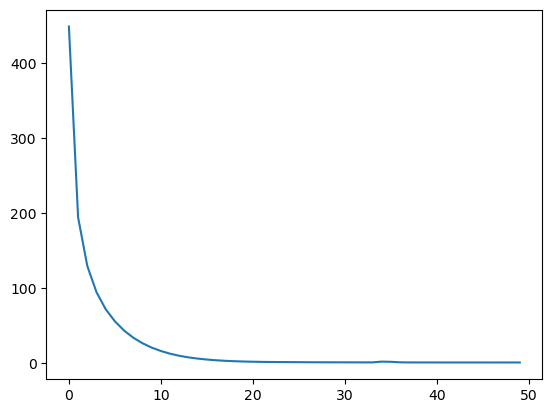

In [23]:
plt.plot(losses)

In [24]:
model.eval()
all_preds, all_labels = [],[]
with torch.no_grad():
    for x,y in test_loader:
        outputs = model(x)
        preds = torch.argmax(outputs,dim = -1)

        all_preds.extend(preds.view(-1).tolist())
        all_labels.extend(y.view(-1).tolist())

In [65]:
# This is done to remove the -1 (paddings)
valid_indices = [i for i, label in enumerate(all_labels) if label != -1]
filtered_labels = [all_labels[i] for i in valid_indices]
filtered_preds = [all_preds[i] for i in valid_indices]

print(f"Filtered labels length: {len(filtered_labels)}")
print(f"Filtered preds length: {len(filtered_preds)}")

Filtered labels length: 47377
Filtered preds length: 47377


In [26]:
print(classification_report(filtered_labels,filtered_preds))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1354
           1       1.00      0.50      0.67         2
           2       0.99      1.00      1.00       434
           3       1.00      0.50      0.67         4
           4       0.84      0.57      0.68       130
           5       1.00      1.00      1.00      1178
           6       1.00      0.99      1.00       814
           7       0.14      0.08      0.11        12
           8       0.93      0.78      0.85       728
           9       0.97      0.91      0.94      1918
          10       0.71      0.86      0.78       202
          11       1.00      1.00      1.00      2390
          13       0.99      0.94      0.96        77
          14       0.97      0.89      0.93      6642
          15       0.97      0.90      0.93       913
          16       1.00      0.99      1.00       316
          17       0.91      0.94      0.92      1679
          18       0.80    

Accuracy - 93%

### Sample Testing

In [44]:
sentence = "The quick fox jumped over the dog"
sentence = sentence.split() # Splits the input sentence into words
inp = torch.tensor([word_vocab[word] for word in sentence]) 
# Maps each sentence to it's integer representation and convert to tensor
outputs = model(inp) # Input is fed into the model

In [45]:
outputs

tensor([[ 1.8981e+00, -3.9388e+00, -4.6404e+00, -7.6772e+00, -7.1070e+00,
         -6.2773e+00, -2.5990e+00, -4.9538e+00, -1.7141e+00, -5.6245e+00,
         -6.8659e+00, -2.5877e+00, -5.6188e+00, -2.4715e+00,  1.7577e+00,
         -3.4109e+00, -4.0954e+00, -2.7489e+00,  7.0745e+00, -5.7531e-01,
         -3.3659e+00, -4.8864e+00, -4.9675e+00, -3.9496e+00, -4.0211e+00,
          2.1439e+01, -1.1646e+01, -1.9131e+00, -1.0769e+01, -6.9047e+00,
         -4.9124e+00, -2.9919e+00, -2.2390e-02, -2.6679e+00, -7.1509e+00,
         -1.2011e+01,  6.4214e+00, -6.6138e+00, -1.2612e+01, -4.0574e-01,
         -1.7654e+00, -2.4012e+00, -2.5922e+00, -1.1253e+01],
        [ 4.1341e+00, -2.0355e+00, -1.0825e+01, -6.3261e-01,  2.7597e+00,
         -8.6108e+00, -5.1579e+00, -2.3910e+00, -6.8450e+00,  2.2216e+00,
         -5.3521e-01, -5.9292e+00, -8.0406e+00, -3.2867e+00,  6.4286e+00,
          1.3817e+00, -6.8315e+00, -6.2847e+00,  5.9865e+00, -3.9262e+00,
         -1.2559e+01, -9.5616e+00, -6.9991e+00, -4

In [46]:
outputs.shape

torch.Size([7, 44])

The input a single vector of 7 words (numerical representation) so each word would have its probabilities along all the classes (44 tags).  
Now we need to find which class has highest probability in for each word and for that we use argmax

In [47]:
output = torch.argmax(outputs,dim=-1)

In [48]:
output

tensor([25, 36, 14, 17, 40, 25, 14])

The above tensor is basically the list of indices of the max probabilities among the 44 classes for each of the word. And since the indices are what the classes/tags are, we can directly map it with our tags

In [49]:
output = output.tolist() # Convert to python list
tags = [idx2tag[idx] for idx in output] # Map the indices to class labels

In [50]:
tags

['DT', 'JJ', 'NN', 'VBD', 'IN', 'DT', 'NN']

- The   - DT    - Determiner    - Correct  
- quick - JJ    - Adjective     - Correct  
- fox   - NN    - Noun          - Correct  
- jump  - VBD   - Verb(Past)    - Correct  
- over  - IN    - Preposition   - Correct  
- the   - DT    - Determiner    - Correct  
- dog   - NN    - Noun          - Correct  

In [51]:
def sample_ouput(sentence):
    sentence = sentence.split() # Splits the input sentence into words
    inp = torch.tensor([word_vocab[word] for word in sentence]) 
    # Maps each sentence to it's integer representation and convert to tensor
    outputs = model(inp) # Input is fed into the model
    output = torch.argmax(outputs,dim=-1)
    output = output.tolist() # Convert to python list
    tags = [idx2tag[idx] for idx in output] # Map the indices to class labels
    return tags

In [54]:
sent1 = "She is reading a book"
out1 = sample_ouput(sent1)
out1
# Expected : ['PRP', 'VBZ', 'VBG', 'DT', 'NN'] (4/5)

['PRP', 'VBZ', 'NN', 'DT', 'NN']

In [56]:
sent2 = "I have never seen such a beautiful view"
out2 = sample_ouput(sent2)
out2
# Expected : ['PRP', 'VBP', 'RB', 'VBN', 'JJ', 'DT', 'JJ', 'NN'] (8/8)

['PRP', 'VBP', 'RB', 'VBN', 'JJ', 'DT', 'JJ', 'NN']

In [59]:
sent3 = "can you help me with this project"
out3 = sample_ouput(sent3)
out3
# Expected : ['MD', 'PRP', 'VB', 'PRP', 'IN', 'DT', 'NN'] (7/7)

['MD', 'PRP', 'VB', 'PRP', 'IN', 'DT', 'NN']

In [61]:
sent4 = "The children were playing in the park"
out4 = sample_ouput(sent4)
out4
# Expected : ['DT', 'NNS', 'VBD', 'VBG', 'IN', 'DT', 'NN'] (7/7)

['DT', 'NNS', 'VBD', 'VBG', 'IN', 'DT', 'NN']